# Sentence Embedding - Présentation générale

* Ce notebook présente différentes techniques de "Sentence Embeddings", permettant de générer des features à partir de phrases (ici des tweets)
* L'objectif est de pouvoir séparer les sentiments des tweets de façon automatique, via un T-SNE, qui permet une réduction des features en 2 dimensions
* C'est un notebook d'exemples afin de mieux comprendre la mise en oeuvre des techniques. Il n'est pas optimisé et doit être adapté à un nouveau contexte, en particulier sur les points suivants :
    * Le nettoyage des textes
    * les modèles BERT (model_type) idéalement pré-entraînés sur des données similaires au contexte (ici le modèle 'cardiffnlp/twitter-roberta-base-sentiment' surperforme le modèle de base car il a été pré-entraîné sur des tweets)
    * La taille des vecteurs (max_length)
    * Le batch_size
    * La perplexité du Tsne (perplexity à 30 par défaut)

# Préparation initiale dataset

## Récupération du dataset et filtres de données

In [1]:
# Import des librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import os
os.environ["OMP_NUM_THREADS"] = '1'

In [3]:
number_cat = 20
tree_level = -1

In [4]:
path_csv = './data/Flipkart/flipkart_com-ecommerce_sample_1050.csv'

In [5]:
data = pd.read_csv(path_csv)

In [6]:
data['product_category_list'] = data['product_category_tree'].apply(lambda e : e[2:-2]).str.split(' >> ')
data['product_category_last'] = data['product_category_list'].apply(lambda e : e[-1])

In [7]:
data = data[['product_name', 'product_category_list', 'description']].copy()
data.columns = ['name', 'category_list', 'description']

In [8]:
data['category'] = data['category_list'].apply(lambda l : l[tree_level] if tree_level<len(l) else l[-1])

In [9]:
data

,name,category_list,description,category
0,Elegance Polyester Multicolor Abstract Eyelet ...,"[Home Furnishing, Curtains & Accessories, Curt...",Key Features of Elegance Polyester Multicolor ...,Elegance Polyester Multicolor Abstract Eyelet ...
1,Sathiyas Cotton Bath Towel,"[Baby Care, Baby Bath & Skin, Baby Bath Towels...",Specifications of Sathiyas Cotton Bath Towel (...,"Sathiyas Cotton Bath Towel (3 Bath Towel, Red,..."
2,Eurospa Cotton Terry Face Towel Set,"[Baby Care, Baby Bath & Skin, Baby Bath Towels...",Key Features of Eurospa Cotton Terry Face Towe...,Eurospa Cotton Terry Face Towel Set (20 PIECE ...
3,SANTOSH ROYAL FASHION Cotton Printed King size...,"[Home Furnishing, Bed Linen, Bedsheets, SANTOS...",Key Features of SANTOSH ROYAL FASHION Cotton P...,SANTOSH ROYAL FASHION Cotton Printed King size...
4,Jaipur Print Cotton Floral King sized Double B...,"[Home Furnishing, Bed Linen, Bedsheets, Jaipur...",Key Features of Jaipur Print Cotton Floral Kin...,Jaipur Print Cotton Floral King sized Double B...
...,...,...,...,...
1045,Oren Empower Extra Large Self Adhesive Sticker,"[Baby Care, Baby & Kids Gifts, Stickers, Oren ...",Oren Empower Extra Large Self Adhesive Sticker...,Oren Empower Stickers
1046,Wallmantra Large Vinyl Sticker Sticker,"[Baby Care, Baby & Kids Gifts, Stickers, Wallm...",Wallmantra Large Vinyl Sticker Sticker (Pack o...,Wallmantra Stickers
1047,Uberlyfe Extra Large Pigmented Polyvinyl Films...,"[Baby Care, Baby & Kids Gifts, Stickers, Uberl...",Buy Uberlyfe Extra Large Pigmented Polyvinyl F...,Uberlyfe Stickers
1048,Wallmantra Medium Vinyl Sticker Sticker,"[Baby Care, Baby & Kids Gifts, Stickers, Wallm...",Buy Wallmantra Medium Vinyl Sticker Sticker fo...,Wallmantra Stickers


<Axes: >

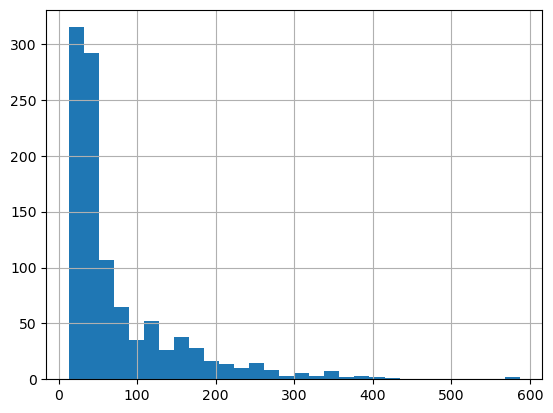

In [10]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in data['description']]

pd.Series(seq_len).hist(bins = 30)

<Axes: >

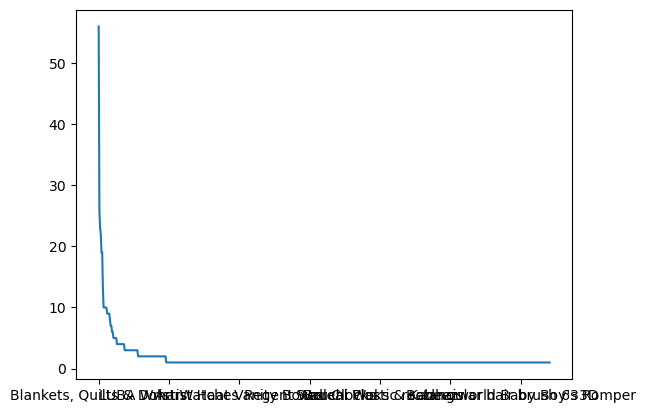

In [11]:
data['category'].value_counts().plot()

In [12]:
len(data['category'].unique())

642

In [13]:
data['category'].value_counts().head(number_cat)

Blankets, Quilts & Dohars                              56
Prithish Coffee Mugs                                   26
Maxima Wrist Watches                                   23
Rockmantra Coffee Mugs                                 22
Towels                                                 19
Sonata Wrist Watches                                   19
Printland Coffee Mugs                                  13
Times Wrist Watches                                    10
Oxyglow Combos and Kits                                10
Lal Haveli Ethnic                                      10
Cushion Covers                                         10
Lapguard Batteries                                     10
Curtains                                                9
Mxofere Combos and Kits                                 9
Perucci Wrist Watches                                   9
Timewel Wrist Watches                                   9
Denver Combos                                           8
Smartpro 19.5v

In [14]:
list_cat = list(data['category'].value_counts().index)[:number_cat]
list_cat

['Blankets, Quilts & Dohars',
 'Prithish Coffee Mugs',
 'Maxima Wrist Watches',
 'Rockmantra Coffee Mugs',
 'Towels',
 'Sonata Wrist Watches',
 'Printland Coffee Mugs',
 'Times Wrist Watches',
 'Oxyglow Combos and Kits',
 'Lal Haveli Ethnic',
 'Cushion Covers',
 'Lapguard Batteries',
 'Curtains',
 'Mxofere Combos and Kits',
 'Perucci Wrist Watches',
 'Timewel Wrist Watches',
 'Denver Combos',
 'Smartpro 19.5v,3.9a Replacement Charger for Vaio...',
 'Tenda Routers',
 'Nutcase Water bottle']

In [15]:
data = data.loc[data['category'].isin(list_cat)].copy()

In [16]:
data['category_num'] = data['category'].apply(lambda e : list_cat.index(e))

In [17]:
data

,name,category_list,description,category,category_num
103,Rama Floral Single Quilts & Comforters Pink-Red,"[Home Furnishing, Bed Linen, Blankets, Quilts ...",Buy Rama Floral Single Quilts & Comforters Pin...,"Blankets, Quilts & Dohars",0
104,Rama Floral Single Quilts & Comforters Yellow,"[Home Furnishing, Bed Linen, Blankets, Quilts ...",Buy Rama Floral Single Quilts & Comforters Yel...,"Blankets, Quilts & Dohars",0
105,Shop Rajasthan Abstract Single Dohar Multicolor,"[Home Furnishing, Bed Linen, Blankets, Quilts ...",Buy Shop Rajasthan Abstract Single Dohar Multi...,"Blankets, Quilts & Dohars",0
107,Artisan Creation Checkered Single Quilts & Com...,"[Home Furnishing, Bed Linen, Blankets, Quilts ...",Artisan Creation Checkered Single Quilts & Com...,"Blankets, Quilts & Dohars",0
108,Rama Floral Single Quilts & Comforters Blue-Beige,"[Home Furnishing, Bed Linen, Blankets, Quilts ...",Buy Rama Floral Single Quilts & Comforters Blu...,"Blankets, Quilts & Dohars",0
...,...,...,...,...,...
945,Unnati Floral Double Blanket Multicolor,"[Home Furnishing, Bed Linen, Blankets, Quilts ...",Buy Unnati Floral Double Blanket Multicolor at...,"Blankets, Quilts & Dohars",0
949,Welhouse Geometric Double Blanket Black,"[Home Furnishing, Bed Linen, Blankets, Quilts ...",Buy Welhouse Geometric Double Blanket Black at...,"Blankets, Quilts & Dohars",0
950,eCraftIndia Floral Single Quilts & Comforters ...,"[Home Furnishing, Bed Linen, Blankets, Quilts ...",Buy eCraftIndia Floral Single Quilts & Comfort...,"Blankets, Quilts & Dohars",0
952,Unnati Abstract Single Top Sheet Multicolor,"[Home Furnishing, Bed Linen, Blankets, Quilts ...",Unnati Abstract Single Top Sheet Multicolor\r\...,"Blankets, Quilts & Dohars",0


## Nettoyage du texte

In [18]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

In [19]:
from nltk.stem.snowball import SnowballStemmer

In [20]:
stemmer = SnowballStemmer(language="english")

nlp = spacy.load("en_core_web_sm")
nlp.add_pipe("sentencizer") # Pour séparer les phrases

# Je préfère garder une trace de la négation
for n in ['no', 'not']:
    if n in STOP_WORDS:
        STOP_WORDS.remove(n)

In [21]:
def get_tokens(text, action='lemma'):
    doc = nlp(text)
    
    # Recapitalisation des phrases pour que
    # Spacy les gères mieux
    text_tmp = ''
    # On sépare en phrases, les capitalises
    # et on reforme le texte complet
    for sent in doc.sents:
        text_tmp += sent.text.capitalize() + ' '

    # On reanalyse le texte
    doc = nlp(text_tmp)

    filtered_tokens = []
    for token in doc:
        # On ignore la ponctuation, les espaces et les chiffres
        if not token.is_punct and not token.is_space and not token.is_digit:
            
            if action == 'lemma':
                normalized_token = token.lemma_.lower()
            elif action == 'norm':
                normalized_token = token.norm_.lower()
            elif action == 'stem':
                normalized_token = stemmer.stem(token.text.lower())
            else:
                normalized_token = token.text.lower()
            
            if normalized_token not in STOP_WORDS:
                filtered_tokens.append(normalized_token)
    return ' '.join(filtered_tokens)

In [22]:
print('Texte Normalisé :')
print(get_tokens("I don't like those 3 black cat, they are sitting on my single mat.", 'lemma'))

print('\nTexte Lemmatisé :')
print(get_tokens("I don't like those 3 black cat, they are sitting on my single mat.", 'norm'))

print('\nTexte Stemmé :')
print(get_tokens("I don't like those 3 black cat, they are sitting on my single mat.", 'stem'))

Texte Normalisé :
not like black cat sit single mat

Texte Lemmatisé :
not like black cat sitting single mat

Texte Stemmé :
like black cat sit singl mat


In [23]:
data_T = data.copy()

In [24]:
data_T['description_text'] = data_T['description'].apply(lambda t : get_tokens(t))
# data_T['description_words'] = data_T['description_text'].str.split(' ')

In [25]:
data_T

,name,category_list,description,category,category_num,description_text
103,Rama Floral Single Quilts & Comforters Pink-Red,"[Home Furnishing, Bed Linen, Blankets, Quilts ...",Buy Rama Floral Single Quilts & Comforters Pin...,"Blankets, Quilts & Dohars",0,buy rama floral single quilt comforter pink re...
104,Rama Floral Single Quilts & Comforters Yellow,"[Home Furnishing, Bed Linen, Blankets, Quilts ...",Buy Rama Floral Single Quilts & Comforters Yel...,"Blankets, Quilts & Dohars",0,buy rama floral single quilt comforter yellow ...
105,Shop Rajasthan Abstract Single Dohar Multicolor,"[Home Furnishing, Bed Linen, Blankets, Quilts ...",Buy Shop Rajasthan Abstract Single Dohar Multi...,"Blankets, Quilts & Dohars",0,buy shop rajasthan abstract single dohar multi...
107,Artisan Creation Checkered Single Quilts & Com...,"[Home Furnishing, Bed Linen, Blankets, Quilts ...",Artisan Creation Checkered Single Quilts & Com...,"Blankets, Quilts & Dohars",0,artisan creation checker single quilt comforte...
108,Rama Floral Single Quilts & Comforters Blue-Beige,"[Home Furnishing, Bed Linen, Blankets, Quilts ...",Buy Rama Floral Single Quilts & Comforters Blu...,"Blankets, Quilts & Dohars",0,buy rama floral single quilt comforter blue be...
...,...,...,...,...,...,...
945,Unnati Floral Double Blanket Multicolor,"[Home Furnishing, Bed Linen, Blankets, Quilts ...",Buy Unnati Floral Double Blanket Multicolor at...,"Blankets, Quilts & Dohars",0,buy unnati floral double blanket multicolor rs...
949,Welhouse Geometric Double Blanket Black,"[Home Furnishing, Bed Linen, Blankets, Quilts ...",Buy Welhouse Geometric Double Blanket Black at...,"Blankets, Quilts & Dohars",0,buy welhouse geometric double blanket black rs...
950,eCraftIndia Floral Single Quilts & Comforters ...,"[Home Furnishing, Bed Linen, Blankets, Quilts ...",Buy eCraftIndia Floral Single Quilts & Comfort...,"Blankets, Quilts & Dohars",0,buy ecraftindia floral single quilt comforter ...
952,Unnati Abstract Single Top Sheet Multicolor,"[Home Furnishing, Bed Linen, Blankets, Quilts ...",Unnati Abstract Single Top Sheet Multicolor\r\...,"Blankets, Quilts & Dohars",0,unnati abstract single sheet multicolor price ...


In [26]:
data_T.to_csv("./data/data_text.csv")

# Préparation commune des traitements

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time
from sklearn import cluster, metrics
from sklearn import manifold, decomposition
import logging

## Lecture dataset

In [28]:
data_T =  pd.read_csv("./data/data_text.csv")
print(data_T.shape)

(292, 7)


In [29]:
l_cat = data_T['category'].unique()
y_cat_num = data_T['category_num']

## Fonctions communes

In [30]:
from sklearn.decomposition import *
from sklearn.preprocessing import StandardScaler
import time

In [31]:
# Calcul Tsne, détermination des clusters et calcul ARI entre vrais catégorie et n° de clusters
def ARI_fct(features, methode='tsne', n_components=2) :
    time1 = time.time()
    num_labels=len(l_cat)
    
    tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000,
                         init='random', learning_rate=200)
    X_tsne = tsne.fit_transform(features)
    
    if methode == 'tsne':
        X = X_tsne
    elif methode == 'nmf':
        model = NMF(n_components=n_components, init='random')
        X = model.fit_transform(features)
    elif methode == 'pca':
        scaler = StandardScaler()
        features = scaler.fit_transform(features)
        
        model = PCA(n_components=n_components)
        X = model.fit_transform(features)
    elif methode == 'sparce_pca':
        model = SparsePCA(n_components=n_components)
        X = model.fit_transform(features.toarray())
        
    
    # Détermination des clusters à partir des données après Tsne 
    cls = cluster.KMeans(n_clusters=num_labels, n_init=100)
    cls.fit(X)
    
    len_min = min(len(y_cat_num), len(cls.labels_))
    ARI = np.round(metrics.adjusted_rand_score(y_cat_num[:len_min], cls.labels_[:len_min]),4)
    time2 = np.round(time.time() - time1,0)
    print("ARI : ", ARI, "time : ", time2)
    
    return ARI, X_tsne, cls.labels_


# visualisation du Tsne selon les vraies catégories et selon les clusters
def TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI) :
    fig = plt.figure(figsize=(15,6))
    
    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=y_cat_num[:len(X_tsne)], cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=list(l_cat), loc="best", title="Categorie")
    plt.title('Représentation des descriptions par catégories réelles')
    
    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=labels[:len(X_tsne)], cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(labels), loc="best", title="Clusters")
    plt.title('Représentation des descriptions par clusters')
    
    plt.show()
    print("ARI : ", ARI)

In [32]:
def get_max_coord(data):
    max_value = data.values.max()
    return list(zip(*np.where(data.values == max_value)))[0]

In [33]:
def compare_clustering(original, predict, return_cat=False):
    original = list(original)
    data_show = pd.DataFrame(original, columns=['cat'])
    data_show['pred'] = predict
    data_show = pd.get_dummies(data_show, columns=['pred'])
    data_show = data_show.groupby('cat').sum(numeric_only=True)
    

    cat_restante = list(data_show.index)
    col_restante = list(data_show.columns)
    cat_final = []
    col_final = []
    for i in range(len(data_show)):
        i_cat, i_col = get_max_coord(data_show.loc[cat_restante, col_restante])
        n_col, n_cat = col_restante[i_col], cat_restante[i_cat]

        col_final.append(n_col)
        col_restante.remove(n_col)
        cat_final.append(n_cat)
        cat_restante.remove(n_cat)
    
    if return_cat:
        return cat_final, col_final

    print('ARI : ', metrics.adjusted_rand_score(original, predict))
    
    return data_show.loc[cat_final, col_final].style.background_gradient(cmap="YlGnBu", axis=0)

# Bag of word - Tf-idf

## Préparation sentences

In [34]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [35]:
feat = 'description_text'

In [36]:
# Version qui fonction un tout petit peu mieux avec PCA
# cvect = CountVectorizer(max_df=0.95, min_df=8, analyzer='char', ngram_range=(3, 6))
# ctf = TfidfVectorizer(max_df=0.95, min_df=8, analyzer='char', ngram_range=(3, 6))

cvect = CountVectorizer(max_df=0.95, min_df=2)
ctf = TfidfVectorizer(max_df=0.95, min_df=1)

cv_fit = cvect.fit(data_T[feat])
ctf_fit = ctf.fit(data_T[feat])

cv_transform = cvect.transform(data_T[feat])  
ctf_transform = ctf.transform(data_T[feat])  

### Analyse de la vectorisation

In [37]:
print("Taille du vocabulaire Count :", len(cvect.get_feature_names_out()))
print("Taille du vocabulaire Tf-Idf :", len(ctf_fit.get_feature_names_out()))

Taille du vocabulaire Count : 569
Taille du vocabulaire Tf-Idf : 1094


In [38]:
# Obtention des mots triés par fréquence décroissante
vocab = cvect.get_feature_names_out()
counts = np.asarray(cv_transform.sum(axis=0)).ravel()
df = pd.DataFrame({"mot": vocab, "nb occurences": counts})
df = df.sort_values("nb occurences", ascending=False)

print("Mots les plus présents :\n", df.head(10))

print("\nMots les moins présents :\n", df.tail(10))

Mots les plus présents :
              mot  nb occurences
336          mug            348
401      product            320
440           rs            266
429  replacement            199
87           buy            198
221         free            196
157     delivery            195
229      genuine            195
94          cash            195
459     shipping            195

Mots les moins présents :
              mot  nb occurences
290         king              2
491       stripe              2
89       caliber              2
85        bucket              2
246  handloomhub              2
503         teal              2
501           te              2
436           ro              2
27           950              2
461       silver              2


In [39]:
feature_names = ctf_fit.get_feature_names_out()
idf_scores = ctf_fit.idf_

df = pd.DataFrame([feature_names, idf_scores], index=['nom', 'score']).T
df = df.sort_values('score', ascending=False)

print("Mots les plus importants :\n", df.head(10))

print("\nMots les moins représentatifs :\n", df.tail(10))

Mots les plus importants :
              nom     score
0      01433cmgy  5.987025
511       gemini  5.987025
563     homeehub  5.987025
567          hop  5.987025
568   horizontal  5.987025
569        horse  5.987025
571  houseattire  5.987025
573          hub  5.987025
575      husband  5.987025
578      ideapad  5.987025

Mots les moins représentatifs :
           nom     score
486  flipkart  1.611268
317       com  1.611268
384  delivery  1.402058
276      cash  1.402058
918  shipping  1.402058
513   genuine  1.402058
497      free  1.396969
264       buy  1.396969
817   product  1.220587
885        rs  1.092924


## Exécution des modèles

In [40]:
print("Version avec PCA")
print("CountVectorizer : ")
print("-----------------")
ARI_cv, X_tsne_cv, labels_cv = ARI_fct(cv_transform, 'sparce_pca', 2)

print()
print("Tf-idf : ")
print("--------")
ARI_ctf, X_tsne_ctf, labels_ctf = ARI_fct(ctf_transform, 'sparce_pca', 2)

Version avec PCA
CountVectorizer : 
-----------------
ARI :  0.4004 time :  18.0

Tf-idf : 
--------
ARI :  0.0564 time :  18.0


In [41]:
print("Version avec NMF")
print("CountVectorizer : ")
print("-----------------")
ARI_cv, X_tsne_cv, labels_cv = ARI_fct(cv_transform, 'nmf', 2)

print()
print("Tf-idf : ")
print("--------")
ARI_ctf, X_tsne_ctf, labels_ctf = ARI_fct(ctf_transform, 'nmf', 2)

Version avec NMF
CountVectorizer : 
-----------------
ARI :  0.4001 time :  14.0

Tf-idf : 
--------
ARI :  0.2953 time :  15.0


In [42]:
print("Version avec T-SNE")
print("CountVectorizer : ")
print("-----------------")
ARI_cv, X_tsne_cv, labels_cv = ARI_fct(cv_transform)

print()
print("Tf-idf : ")
print("--------")
ARI_ctf, X_tsne_ctf, labels_ctf = ARI_fct(ctf_transform)

Version avec T-SNE
CountVectorizer : 
-----------------
ARI :  0.6636 time :  16.0

Tf-idf : 
--------
ARI :  0.7101 time :  15.0


## Graphiques

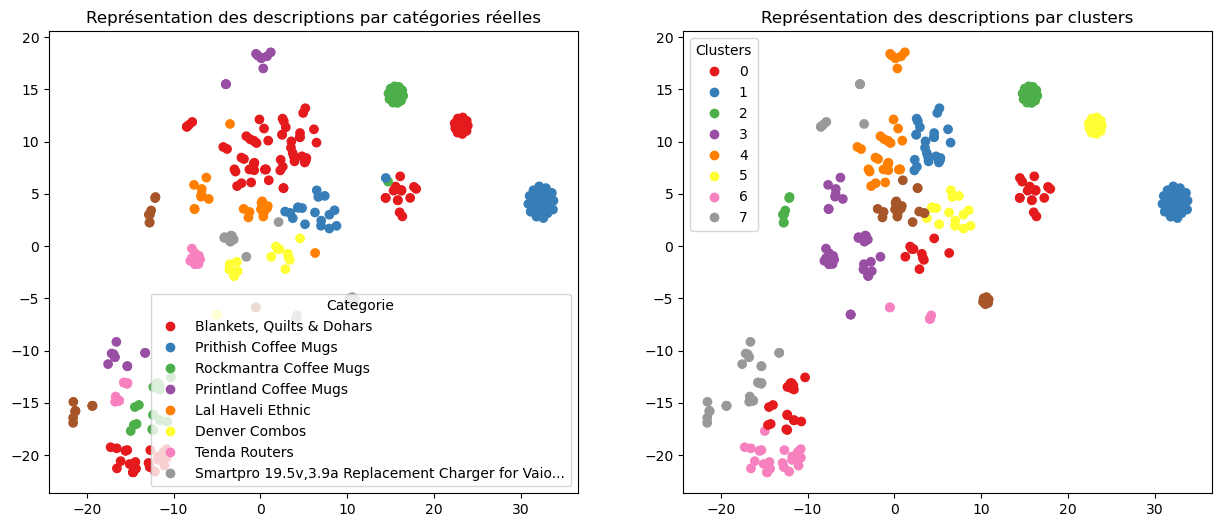

ARI :  0.6636


In [43]:
TSNE_visu_fct(X_tsne_cv, y_cat_num, labels_cv, ARI_cv)

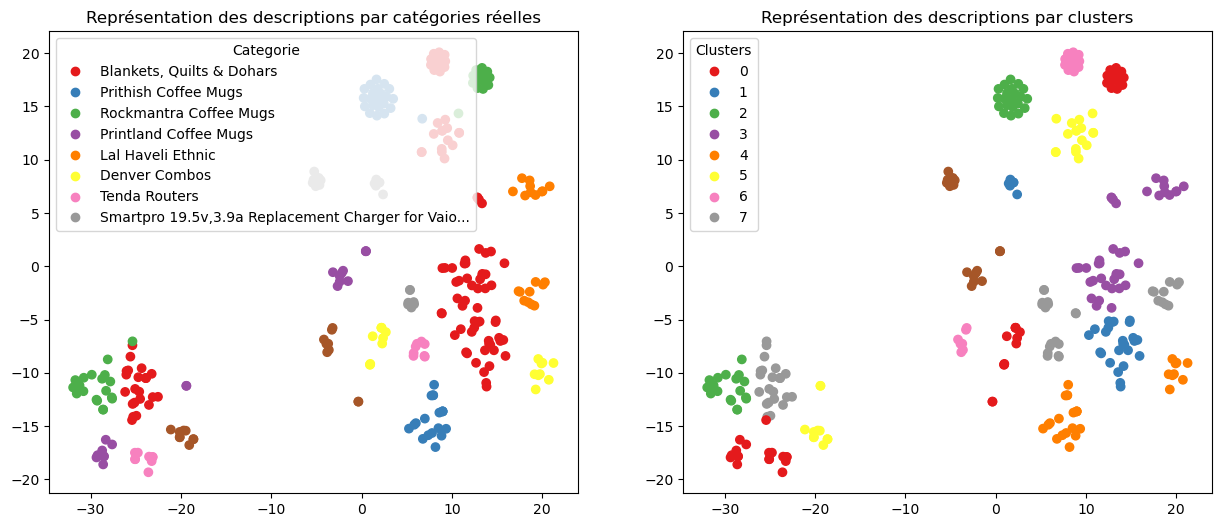

ARI :  0.7101


In [44]:
TSNE_visu_fct(X_tsne_ctf, y_cat_num, labels_ctf, ARI_ctf)

In [45]:
list_cat = list(data_T['category'])

In [46]:
compare_clustering(list_cat, labels_ctf)

ARI :  0.7100693392086739


,pred_3,pred_19,pred_6,pred_9,pred_5,pred_12,pred_2,pred_18,pred_8,pred_0,pred_13,pred_10,pred_11,pred_1,pred_17,pred_15,pred_14,pred_4,pred_7,pred_16
cat,,,,,,,,,,,,,,,,,,,,
"Blankets, Quilts & Dohars",25,0,0,0,0,0,0,0,4,0,0,0,0,0,2,0,0,0,25,0
Maxima Wrist Watches,0,22,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
Rockmantra Coffee Mugs,0,0,21,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Towels,0,0,0,19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Sonata Wrist Watches,0,1,0,0,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Prithish Coffee Mugs,0,0,0,0,0,15,0,0,0,0,0,0,0,0,0,0,0,0,0,11
Printland Coffee Mugs,0,0,0,0,0,1,12,0,0,0,0,0,0,0,0,0,0,0,0,0
Cushion Covers,0,0,0,0,0,0,0,10,0,0,0,0,0,0,0,0,0,0,0,0
Lal Haveli Ethnic,0,0,0,0,0,0,0,0,10,0,0,0,0,0,0,0,0,0,0,0


In [47]:
compare_clustering(y_cat_num, labels_ctf)

ARI :  0.7100693392086739


,pred_3,pred_19,pred_6,pred_9,pred_5,pred_12,pred_2,pred_13,pred_8,pred_18,pred_0,pred_10,pred_11,pred_1,pred_17,pred_15,pred_14,pred_4,pred_7,pred_16
cat,,,,,,,,,,,,,,,,,,,,
0,25,0,0,0,0,0,0,0,4,0,0,0,0,0,2,0,0,0,25,0
2,0,22,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,0,0,21,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,1,0,0,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,15,0,0,0,0,0,0,0,0,0,0,0,0,0,11
6,0,0,0,0,0,1,12,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,10,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,10,0,0,0,0,0,0,0,0,0,0,0


# Word2Vec

In [48]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import gensim
import gensim.downloader as api

## Création du modèle Word2Vec

In [49]:
w2v_size=25
w2v_window=5
w2v_min_count=0
w2v_epochs=100
maxlen = 24 # adapt to length of sentences
sentences = data_T[feat].to_list()
sentences = [gensim.utils.simple_preprocess(text) for text in sentences]

In [50]:
# Création et entraînement du modèle Word2Vec

print("Build & train Word2Vec model ...")
w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count, window=w2v_window,
                                                vector_size=w2v_size,
                                                workers=3)
w2v_model.build_vocab(sentences)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
model_vectors = w2v_model.wv

Build & train Word2Vec model ...


In [51]:
w2v_words = model_vectors.index_to_key
print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec trained")

Vocabulary size: 926
Word2Vec trained


In [52]:
# Préparation des sentences (tokenization)

print("Fit Tokenizer ...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences),
                                                     maxlen=maxlen,
                                                     padding='post')
                                                   
num_words = len(tokenizer.word_index) + 1
print("Number of unique words: %i" % num_words)

Fit Tokenizer ...
Number of unique words: 927


## Création de la matrice d'embedding

In [53]:
# Création de la matrice d'embedding

print("Create Embedding matrix ...")
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_size))
i=0
j=0
    
for word, idx in word_index.items():
    i +=1
    if word in w2v_words:
        j +=1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]
            
word_rate = np.round(j/i,4)
print("Word embedding rate : ", word_rate)
print("Embedding matrix: %s" % str(embedding_matrix.shape))

Create Embedding matrix ...
Word embedding rate :  1.0
Embedding matrix: (927, 25)


## Création du modèle d'embedding

In [54]:
# Création du modèle

input=Input(shape=(len(x_sentences),maxlen),dtype='float64')
word_input=Input(shape=(maxlen,),dtype='float64')  
word_embedding=Embedding(input_dim=vocab_size,
                         output_dim=w2v_size,
                         weights = [embedding_matrix],
                         input_length=maxlen)(word_input)
word_vec=GlobalAveragePooling1D()(word_embedding)  
embed_model = Model([word_input],word_vec)

embed_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 24)]              0         
                                                                 
 embedding (Embedding)       (None, 24, 25)            23175     
                                                                 
 global_average_pooling1d (G  (None, 25)               0         
 lobalAveragePooling1D)                                          
                                                                 
Total params: 23,175
Trainable params: 23,175
Non-trainable params: 0
_________________________________________________________________


## Exécution du modèle

In [55]:
embeddings = embed_model.predict(x_sentences)
embeddings.shape

10/10 [==============================] - 0s 2ms/step


(292, 25)

Version T-SNE
ARI :  0.5213 time :  16.0


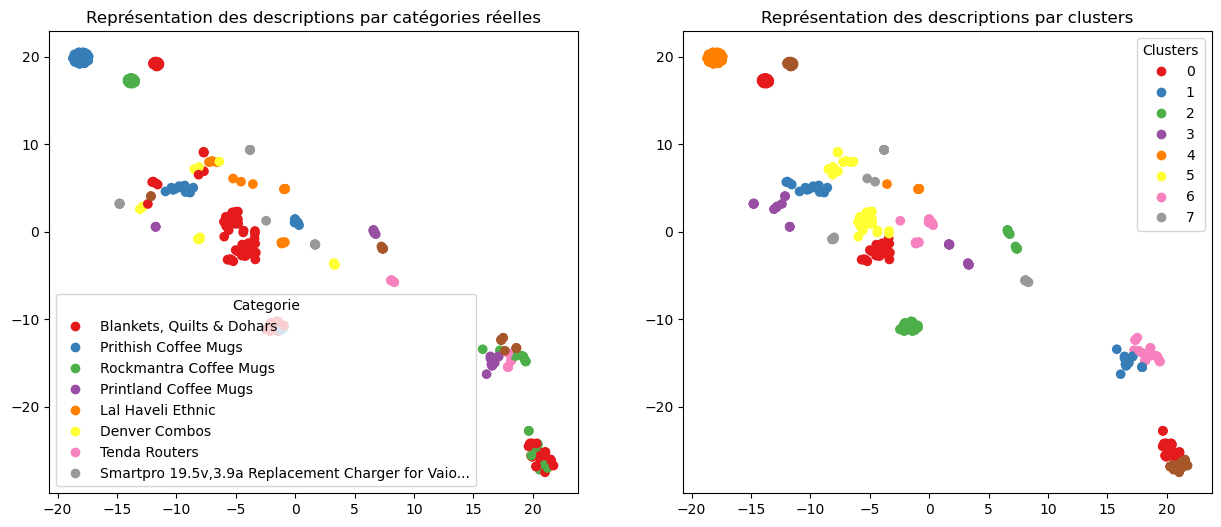

ARI :  0.5213


In [56]:
print("Version T-SNE")
ARI, X_tsne, labels = ARI_fct(embeddings)
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

Version PCA
ARI :  0.5946 time :  15.0


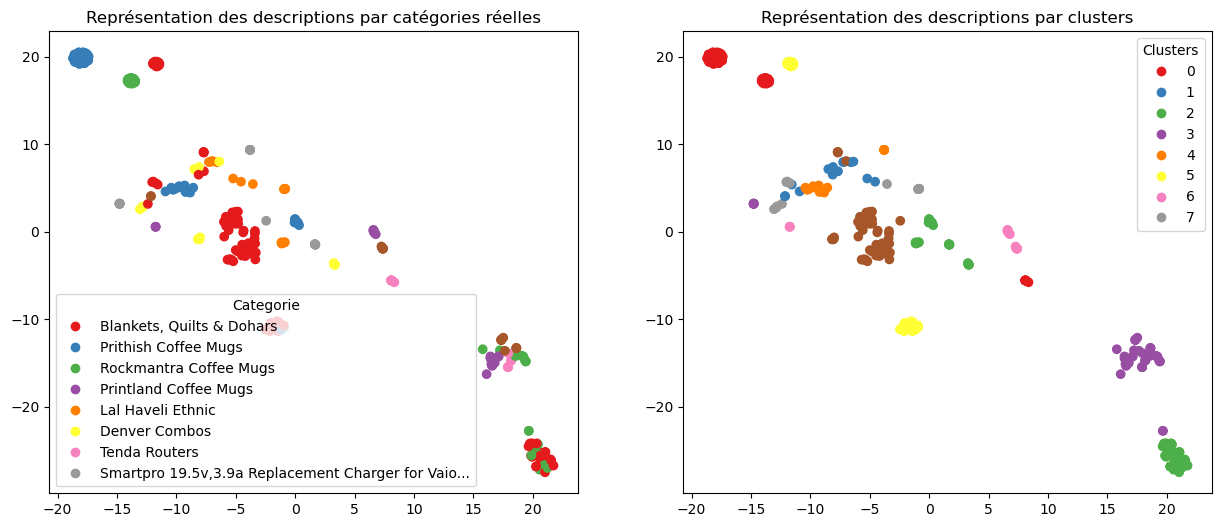

ARI :  0.5946


In [57]:
print("Version PCA")
ARI, _, labels = ARI_fct(embeddings, 'pca', 12)
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

# BERT

In [58]:
import tensorflow as tf
# import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

# Bert
import os
import transformers
from transformers import BertModel, TFBertModel, TFAutoModel, AutoTokenizer

os.environ["TF_KERAS"]='1'

In [59]:
print(tf.__version__)
print(tensorflow.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

2.10.0
2.10.0
Num GPUs Available:  0
False


## Fonctions communes

In [60]:
# Fonction de préparation des sentences
def bert_inp_fct(sentences, bert_tokenizer, max_length) :
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens = True,
                                              max_length = max_length,
                                              padding='max_length',
                                              return_attention_mask = True, 
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")
    
        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0], 
                             bert_inp['token_type_ids'][0], 
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)
    
    return input_ids, token_type_ids, attention_mask, bert_inp_tot
    

# Fonction de création des features
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF') :
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size], 
                                                                      bert_tokenizer, max_length)
        
        if mode=='HF' :    # Bert HuggingFace
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode=='TFhub' : # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids" : input_ids, 
                                 "input_mask" : attention_mask, 
                                 "input_type_ids" : token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']
             
        if step ==0 :
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))
    
    features_bert = np.array(last_hidden_states_tot).mean(axis=1)
    
    time2 = np.round(time.time() - time1,0)
    print("temps traitement : ", time2)
     
    return features_bert, last_hidden_states_tot

## BERT HuggingFace

### 'bert-base-uncased'

In [61]:
max_length = 16
batch_size = 25
model_type = 'bert-base-uncased'
model = TFAutoModel.from_pretrained(model_type)
sentences = data_T[feat].to_list()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [62]:
# Création des features

features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, 
                                                         max_length, batch_size, mode='HF')

1/1 [==============================] - 1s 1s/step
temps traitement :  20.0


Version T-SNE
ARI :  0.6784 time :  16.0


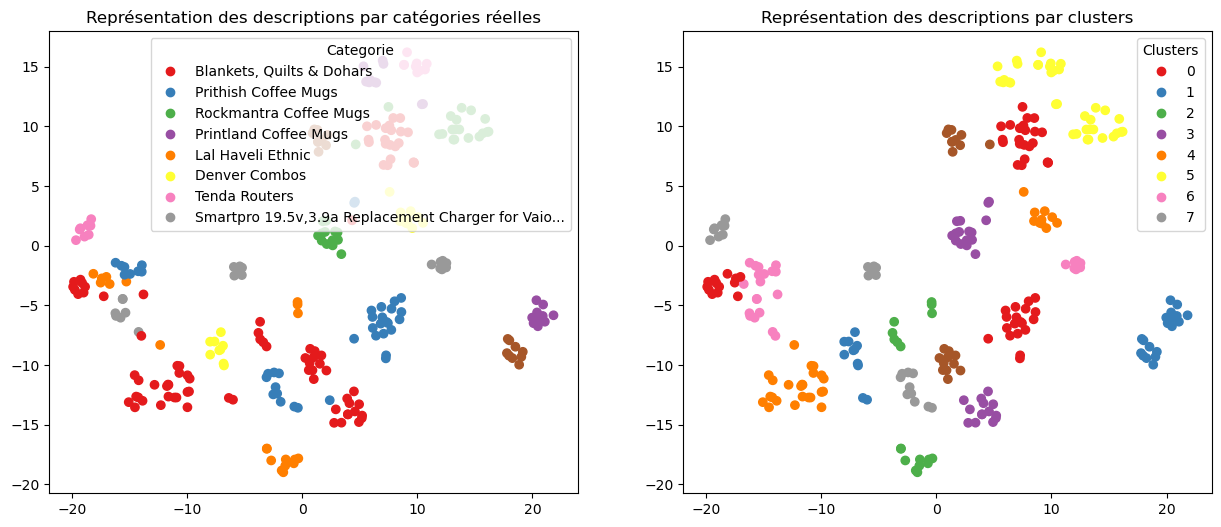

ARI :  0.6784


In [63]:
print("Version T-SNE")
ARI, X_tsne, labels = ARI_fct(features_bert)
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

Version PCA
ARI :  0.5842 time :  15.0


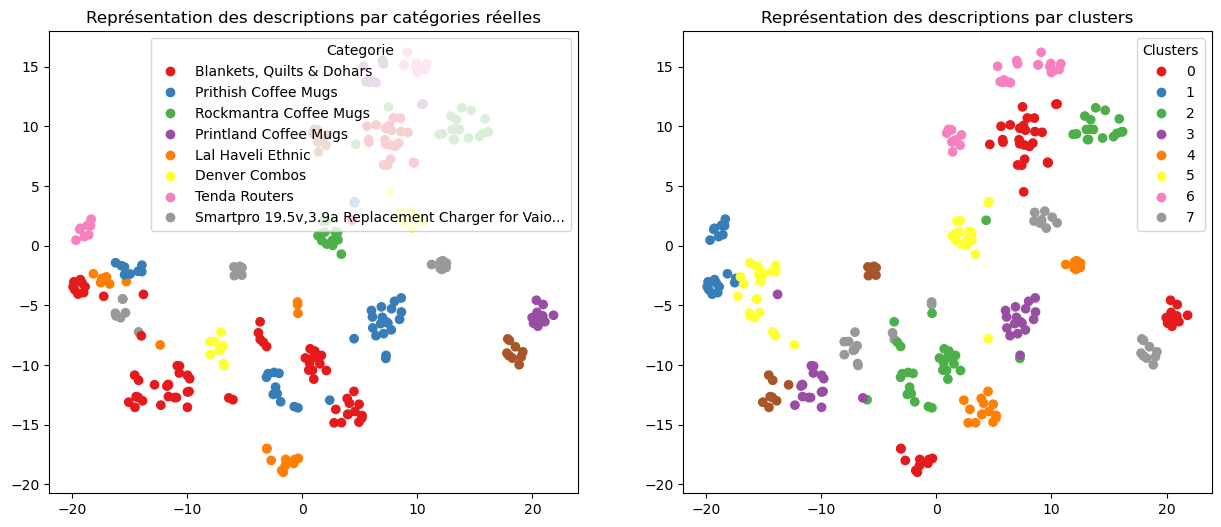

ARI :  0.5842


In [64]:
print("Version PCA")
ARI, _, labels = ARI_fct(features_bert, 'pca', 20)
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

## BERT hub Tensorflow

In [65]:
import tensorflow_hub as hub
import tensorflow_text 

# Guide sur le Tensorflow hub : https://www.tensorflow.org/text/tutorials/classify_text_with_bert
model_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'
bert_layer = hub.KerasLayer(model_url, trainable=True)

In [66]:
sentences = data_T[feat].to_list()

In [67]:
max_length = 16
batch_size = 30
model_type = 'bert-base-uncased'
model = bert_layer

features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, 
                                                         max_length, batch_size, mode='TFhub')

temps traitement :  13.0


Version T-SNE
ARI :  0.712 time :  17.0


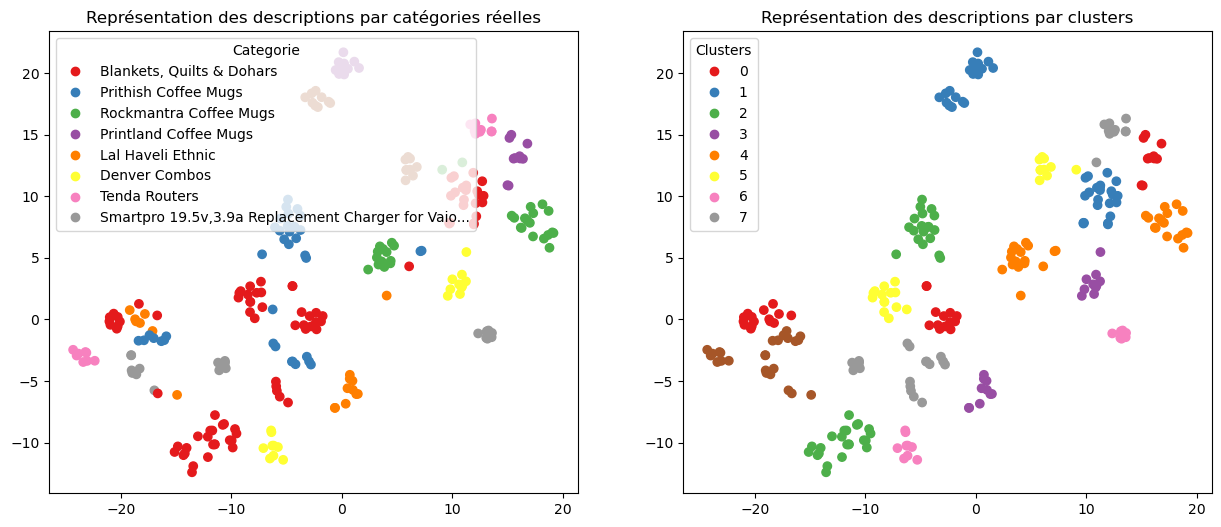

ARI :  0.712


In [68]:
print("Version T-SNE")
ARI, X_tsne, labels = ARI_fct(features_bert)
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

Version PCA
ARI :  0.595 time :  16.0


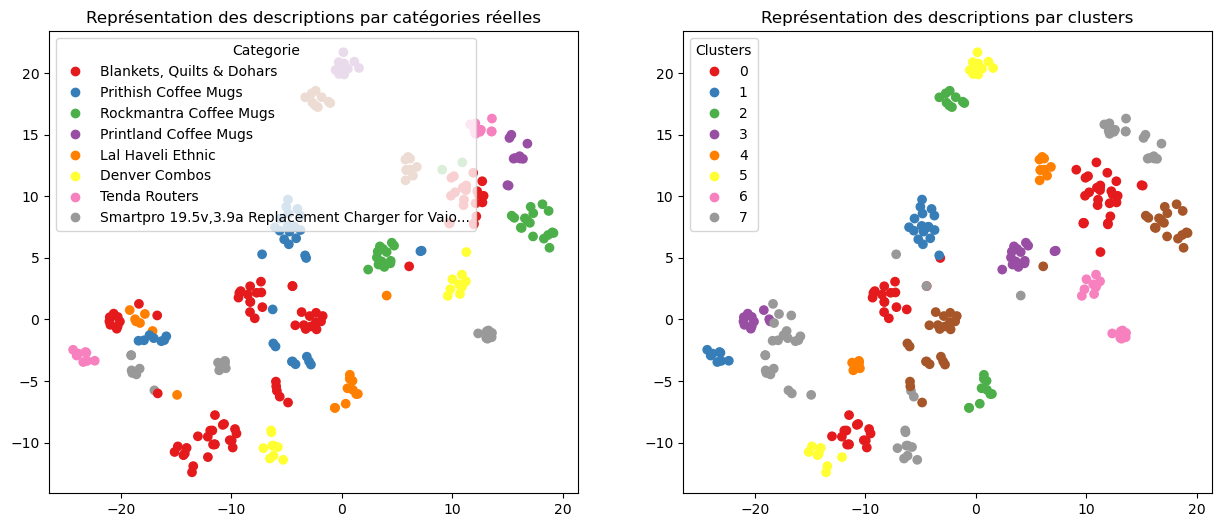

ARI :  0.595


In [69]:
print("Version PCA")
ARI, _, labels = ARI_fct(features_bert, 'pca', 20)
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

# USE - Universal Sentence Encoder

In [70]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

os.environ["TF_KERAS"]='1'

In [71]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [72]:
def feature_USE_fct(sentences, b_size) :
    batch_size = b_size
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))

    time2 = np.round(time.time() - time1,0)
    return features

In [73]:
batch_size = 50
sentences = data_T[feat].to_list()

In [74]:
features_USE = feature_USE_fct(sentences, batch_size)

Version T-SNE
ARI :  0.6627 time :  16.0


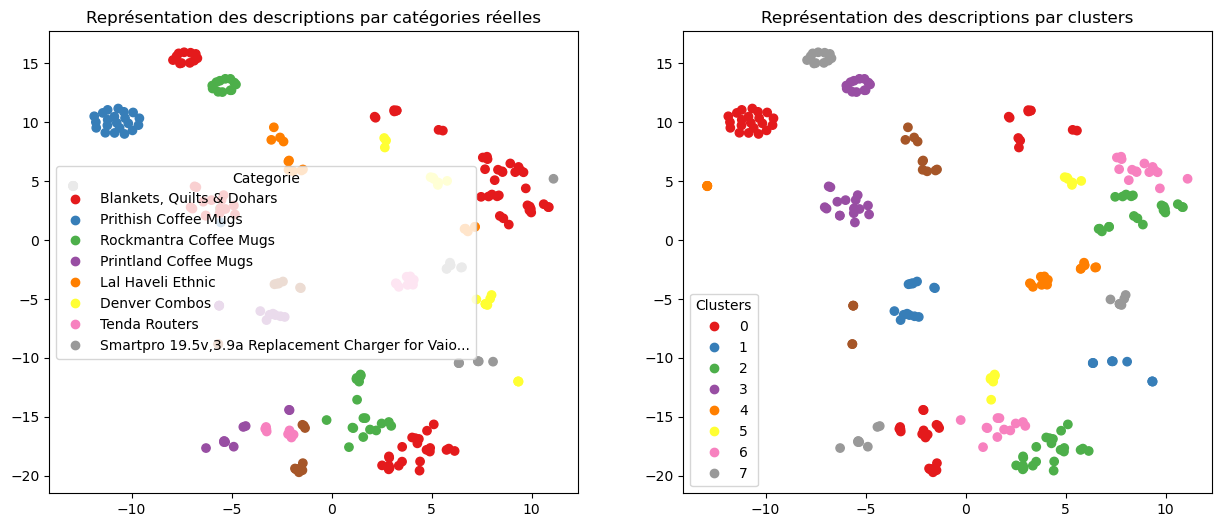

ARI :  0.6627


In [75]:
print("Version T-SNE")
ARI, X_tsne, labels = ARI_fct(features_USE)
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

Version PCA
ARI :  0.6086 time :  15.0


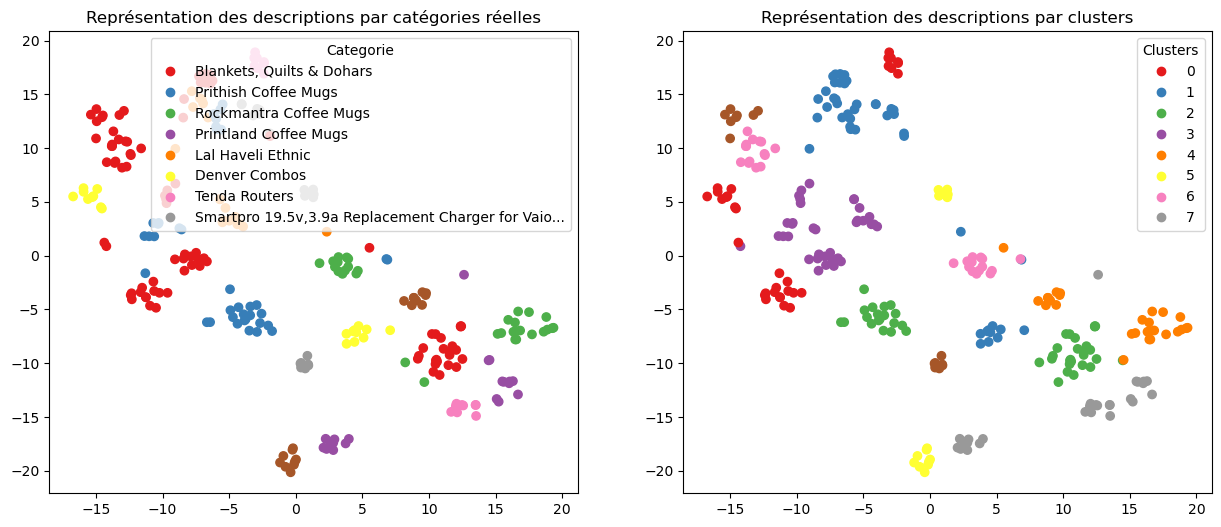

ARI :  0.6086


In [76]:
print("Version PCA")
ARI, X_tsne, labels = ARI_fct(features_bert, 'pca', 30)
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)